In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import precision_score, recall_score

import numpy as np
import matplotlib.pyplot as plt
import os
import statistics

from PIL import Image
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\Adedamola\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
data_transforms = transforms.Compose([])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Load the training Dataset
dataset = ImageFolder('Fruits/Train', transform = data_transforms)

In [5]:
test_dataset = ImageFolder('Fruits/Test', transform = test_transform)

In [6]:
class_names = dataset.classes
print(class_names)

['Apple', 'Banana', 'Grape', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


In [7]:
num_classes = len(class_names)
batch_size = 32
num_epochs = 10
num_folds = 5

In [8]:
# Load the pre-trained AlexNet model
alexnet = models.alexnet(pretrained = True)
alexnet

C:\Users\Adedamola\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Adedamola\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [10]:
# Modify the last fully connected layer to match the number of classes in your dataset
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_features, 8)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

num_features = alexnet.classifier[6].in_features
dropout_prob = 0.5  # Set the dropout probability
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 512),      # Update the number of output features
    nn.LayerNorm(512),                # Add batch normalization
    nn.ReLU(inplace=True),
    nn.Dropout(dropout_prob),          # Add dropout layer
    nn.Linear(512, 2),                 # Update the number of output features
    nn.LogSoftmax(dim = 1)
)

In [11]:
# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.005, momentum=0.9)#,weight_decay=1e-5)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [12]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)
loss_func.to(device)

CrossEntropyLoss()

In [14]:
class_idx_to_label = dataset.classes

# Print the class index-label mapping
for idx, label in enumerate(class_idx_to_label):
    print(f"Class Index {idx}: Class Label {label}")

Class Index 0: Class Label Apple
Class Index 1: Class Label Banana
Class Index 2: Class Label Grape
Class Index 3: Class Label mango
Class Index 4: Class Label orange
Class Index 5: Class Label pinenapple
Class Index 6: Class Label strawberries
Class Index 7: Class Label watermelon


In [15]:
# Perform k-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True)

train_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to a larger size
    transforms.CenterCrop(227),  # Center crop to match AlexNet's input size
    transforms.RandomHorizontalFlip(),  # Horizontal flip with 50% probability
    transforms.RandomRotation(degrees=20),  # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color jitter
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize  
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

accuracies = []  # To store the accuracies for each fold
fold_confusion_matrices = []
Maximum_Values = []
Fold_Num = []
train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for fold, (train_indices, val_indices) in enumerate(skf.split(dataset, dataset.targets)):
    Fold_Num.append(fold + 1)  # Append the fold number to the list
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the dataset into training and validation sets for this fold
    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)
    
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_transform
    
    # Create data loaders with augmented data
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    
    
    for epoch in range(num_epochs):
        # Training phase
        alexnet.train()
        train_loss = 0.0
        train_correct = 0
        train_total_samples = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = alexnet(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

            train_loss += loss.item() * images.size(0)
            train_total_samples += labels.size(0)

        # Calculate the training accuracy and loss for this epoch
        train_accuracy = train_correct / train_total_samples
        train_loss_avg = train_loss / train_total_samples

        # Validation phase
        alexnet.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = alexnet(images)
                loss = loss_func(outputs, labels)

                # Calculate the number of correct predictions
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

                val_loss += loss.item() * images.size(0)
                val_total_samples += labels.size(0)

        # Calculate the validation accuracy and loss for this epoch
        val_accuracy = val_correct / val_total_samples
        val_loss_avg = val_loss / val_total_samples
        
        train_acc_values.append(train_accuracy)
        val_acc_values.append(val_accuracy)
        train_loss_values.append(train_loss_avg)
        val_loss_values.append(val_loss_avg)
        
        # Print the train ing and validation loss and accuracy for this epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss_avg:.4f}, Training Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
    # Testing phase
    alexnet.eval()
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
             
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = alexnet(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Convert tensors to lists and extend the true_labels and predicted_labels lists
            true_labels.extend(labels.cpu().numpy().tolist())
            predicted_labels.extend(predicted.cpu().numpy().tolist())

    # Calculate the confusion matrix for this fold
    cm = confusion_matrix(true_labels, predicted_labels)
            
    # Outside the testing phase loop, calculate precision and recall for each fold
    #Save the model for this fold
    model_path = f"Models/Alexnet_Fold {fold + 1}.pt"
    torch.save(alexnet.state_dict(), model_path)
    
    # Record the accuracy for this fold
    accuracies.append(val_accuracy)
    fold_confusion_matrices.append(cm)
    
# Print the confusion matrix for each fold
for i, cm in enumerate(fold_confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}:\n{cm}")

# Print the accuracy for each fold and the average accuracy
for i, accuracy in enumerate(accuracies):
    print(f"Fold {i+1} Accuracy: {accuracy:.4f}")

average_accuracy = sum(accuracies) / num_folds
print(f"Average Validation Accuracy: {average_accuracy:.4f}")



Fold 1/5
Epoch 1/10, Training Loss: 1.4196, Training Accuracy: 0.7528, Validation Loss: 1.1531, Validation Accuracy: 0.8274
Epoch 2/10, Training Loss: 1.2405, Training Accuracy: 0.8103, Validation Loss: 1.3291, Validation Accuracy: 0.8158
Epoch 3/10, Training Loss: 1.1418, Training Accuracy: 0.8327, Validation Loss: 1.0471, Validation Accuracy: 0.8548
Epoch 4/10, Training Loss: 1.0093, Training Accuracy: 0.8483, Validation Loss: 1.1186, Validation Accuracy: 0.8455
Epoch 5/10, Training Loss: 0.9778, Training Accuracy: 0.8518, Validation Loss: 1.0795, Validation Accuracy: 0.8464
Epoch 6/10, Training Loss: 0.9198, Training Accuracy: 0.8589, Validation Loss: 1.1134, Validation Accuracy: 0.8512
Epoch 7/10, Training Loss: 0.9448, Training Accuracy: 0.8629, Validation Loss: 1.3236, Validation Accuracy: 0.8327
Epoch 8/10, Training Loss: 0.8931, Training Accuracy: 0.8692, Validation Loss: 1.3228, Validation Accuracy: 0.8438
Epoch 9/10, Training Loss: 0.9011, Training Accuracy: 0.8673, Validatio

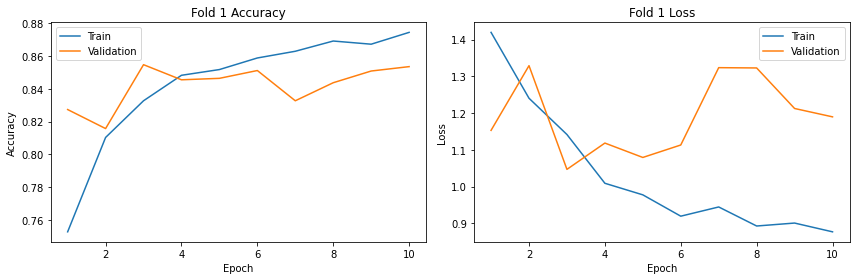

Fold 1 - Train Accuracies: [0.7527529761904762, 0.8103422619047619, 0.8327380952380953, 0.8482886904761905, 0.8517857142857143, 0.8588541666666667, 0.8629464285714286, 0.8691964285714285, 0.8672619047619048, 0.8744791666666667]
Fold 1 - Val Accuracies: [0.8273809523809523, 0.8157738095238095, 0.8547619047619047, 0.8455357142857143, 0.8464285714285714, 0.8511904761904762, 0.8327380952380953, 0.84375, 0.8508928571428571, 0.8535714285714285]
Fold 1 - Train Losses: [1.419594962061161, 1.2404747541594718, 1.141837550699711, 1.0092612559574523, 0.9777936199344583, 0.9197812922254559, 0.9448395559458904, 0.89306179309954, 0.9010779225461495, 0.8772311746497594]
Fold 1 - Val Losses: [1.1531420276056799, 1.3290592701501391, 1.0470923889228807, 1.1185984272687208, 1.0794660788295525, 1.1133543752311241, 1.3236422013779832, 1.3228438662803021, 1.2126229599384324, 1.1898710249479683]


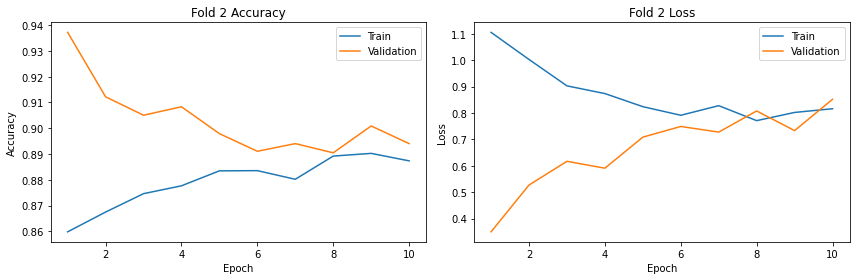

Fold 2 - Train Accuracies: [0.8598214285714286, 0.867485119047619, 0.8746279761904762, 0.8776785714285714, 0.8834821428571429, 0.8835565476190477, 0.8802083333333334, 0.8892113095238096, 0.8902529761904762, 0.8873511904761905]
Fold 2 - Val Accuracies: [0.937202380952381, 0.9122023809523809, 0.9050595238095238, 0.9083333333333333, 0.8979166666666667, 0.8910714285714286, 0.8940476190476191, 0.8904761904761904, 0.9008928571428572, 0.8940476190476191]
Fold 2 - Train Losses: [1.105699482010234, 1.0030265296780965, 0.9029318980481809, 0.8737296008599168, 0.8241358482622586, 0.7914367835668686, 0.827832759968892, 0.7711161646391875, 0.8021780409373778, 0.8161876977996577]
Fold 2 - Val Losses: [0.34961165602950917, 0.5269931370572998, 0.6168852073096094, 0.5908754712627082, 0.7085517278123007, 0.7489914566429521, 0.7276300433920575, 0.8077712898565811, 0.733297945012884, 0.8519547460761064]


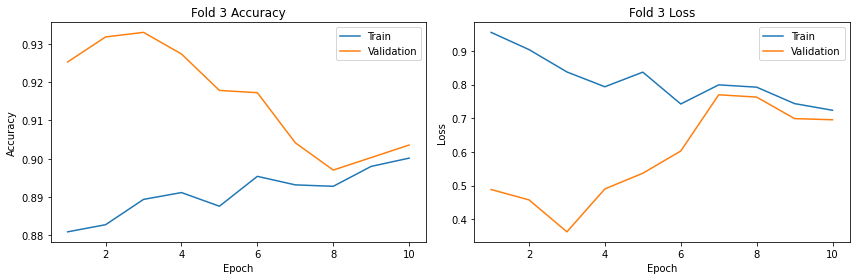

Fold 3 - Train Accuracies: [0.8808779761904761, 0.8827380952380952, 0.889360119047619, 0.8911458333333333, 0.8875744047619047, 0.8953869047619047, 0.893154761904762, 0.8927827380952381, 0.8979910714285714, 0.9001488095238095]
Fold 3 - Val Accuracies: [0.9252976190476191, 0.9318452380952381, 0.9330357142857143, 0.9273809523809524, 0.9178571428571428, 0.9172619047619047, 0.9041666666666667, 0.8970238095238096, 0.9002976190476191, 0.9035714285714286]
Fold 3 - Train Losses: [0.9549794142475418, 0.9038179340938638, 0.8373840991973078, 0.7933979289208115, 0.8368176397214224, 0.7422306425525762, 0.7989993641789798, 0.7921595513990908, 0.7433105124951864, 0.723511573075666]
Fold 3 - Val Losses: [0.4881348536952698, 0.45719978628750935, 0.3623687571060145, 0.48991339782530435, 0.5364388970667776, 0.6025035404199073, 0.7695528558718728, 0.7626667680216823, 0.6987333859838059, 0.6953485309874528]


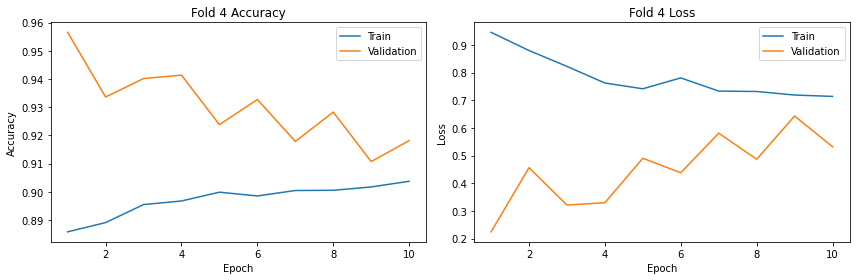

Fold 4 - Train Accuracies: [0.8857886904761905, 0.8890625, 0.8954613095238095, 0.8967261904761905, 0.8998511904761904, 0.8985119047619048, 0.9004464285714285, 0.9005208333333333, 0.9017113095238095, 0.903720238095238]
Fold 4 - Val Accuracies: [0.9565476190476191, 0.9336309523809524, 0.9401785714285714, 0.9413690476190476, 0.9238095238095239, 0.9327380952380953, 0.9178571428571428, 0.9282738095238096, 0.9107142857142857, 0.9181547619047619]
Fold 4 - Train Losses: [0.945313285598864, 0.8798503287582814, 0.8223451766495903, 0.7623334537892377, 0.7414814643111424, 0.7808195654149434, 0.7331602554208768, 0.7316877552343136, 0.7189080474635592, 0.713909973635271]
Fold 4 - Val Losses: [0.22452271989302625, 0.4562310439603462, 0.3212351972949112, 0.32983671755931493, 0.4905118780033765, 0.4379306897965412, 0.5810724978962731, 0.48682005994260963, 0.6429472171055663, 0.5319745978845799]


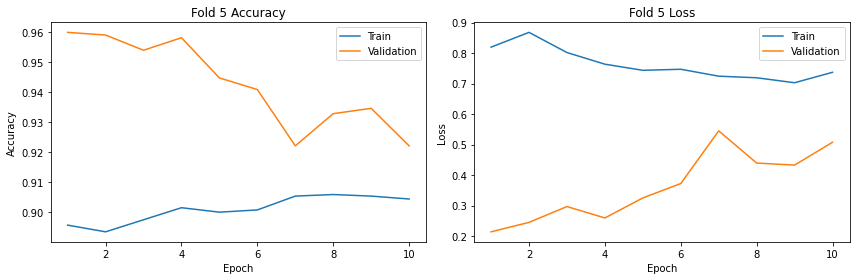

Fold 5 - Train Accuracies: [0.895610119047619, 0.8933779761904762, 0.8973958333333333, 0.9014136904761905, 0.8999255952380952, 0.9006696428571429, 0.9052827380952381, 0.9058035714285714, 0.9052827380952381, 0.9043154761904761]
Fold 5 - Val Accuracies: [0.9598214285714286, 0.9589285714285715, 0.9538690476190477, 0.9580357142857143, 0.9446428571428571, 0.9407738095238095, 0.9220238095238096, 0.9327380952380953, 0.9345238095238095, 0.9220238095238096]
Fold 5 - Train Losses: [0.8197771367156834, 0.8682397143130531, 0.8020752015897111, 0.7638789210496941, 0.7438027411553472, 0.7471980687902985, 0.7245704580146983, 0.7193046610005521, 0.703036360870233, 0.7372889281673235]
Fold 5 - Val Losses: [0.21392090158125265, 0.24492139666034626, 0.2968405834120452, 0.2594348622125633, 0.3251368806721159, 0.3723229165658671, 0.5451890735188581, 0.43951991361527737, 0.43283880035648625, 0.5077484592792278]


In [16]:
## Plot learning curves for each fold
for fold in range(num_folds):
    plt.figure(figsize=(12, 4))
    
    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_acc_values[fold*num_epochs:(fold+1)*num_epochs], label='Train')
    plt.plot(range(1, num_epochs + 1), val_acc_values[fold*num_epochs:(fold+1)*num_epochs], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold+1} Accuracy')
    plt.legend()
    
    # Plot training loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_loss_values[fold*num_epochs:(fold+1)*num_epochs], label='Train')
    plt.plot(range(1, num_epochs + 1), val_loss_values[fold*num_epochs:(fold+1)*num_epochs], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold+1} Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    # Debugging prints
    print(f"Fold {fold+1} - Train Accuracies: {train_acc_values[fold*num_epochs:(fold+1)*num_epochs]}")
    print(f"Fold {fold+1} - Val Accuracies: {val_acc_values[fold*num_epochs:(fold+1)*num_epochs]}")
    print(f"Fold {fold+1} - Train Losses: {train_loss_values[fold*num_epochs:(fold+1)*num_epochs]}")
    print(f"Fold {fold+1} - Val Losses: {val_loss_values[fold*num_epochs:(fold+1)*num_epochs]}")

In [17]:
# List of fold names
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Find index with highest accuracy
highest_accuracy_index = accuracies.index(max(accuracies))

print(f"Highest Accuracy: {folds[highest_accuracy_index]}")

Highest Accuracy: Fold 5


In [19]:
import torch
import torch.nn as nn
from torchvision import models

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = models.alexnet(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
            #nn.LayerNorm(512, eps=1e-05, elementwise_affine=True),
            #nn.ReLU(inplace=True),
            #nn.Dropout(0.5),
            #nn.Linear(512, num_classes),
            #nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [20]:
# Define data transformations for test
predict_transform = transforms.Compose([
    transforms.Resize(227),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(model, image_path):
    # Load the image using PIL
    image = Image.open(image_path)
    plt.imshow(image)
    # Apply the data transformations
    image_tensor = predict_transform(image)

    # Add a batch dimension since the model expects batched input
    image_tensor = image_tensor.unsqueeze(0)

    # Move the tensor to the appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform the inference
    with torch.no_grad():
        output = model(image_tensor)

    # Get the predicted class index and corresponding class name
    _, predicted_indices = torch.max(output, 1)
    predicted_class_index = predicted_indices.item()
    predicted_class = class_names[predicted_class_index]

    # Get the prediction scores for the predicted class
    softmax_scores = torch.softmax(output, dim=1)
    predicted_class_score = softmax_scores[0][predicted_class_index].item()

    # Print the prediction results with the actual class names
    print(f"Predicted Class: {predicted_class}")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Score: {softmax_scores[0][i].item():.2f}")

In [21]:
# Load the saved model
alexnet_model = AlexNet(num_classes)  # Create an instance of the AlexNet class
alexnet_state_dict = torch.load(f'Models/Alexnet_Fold 5.pt')  
alexnet_model.load_state_dict(alexnet_state_dict)

C:\Users\Adedamola\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Adedamola\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

Predicted Class: mango
Apple Score: 0.00
Banana Score: 0.00
Grape Score: 0.00
mango Score: 1.00
orange Score: 0.00
pinenapple Score: 0.00
strawberries Score: 0.00
watermelon Score: 0.00


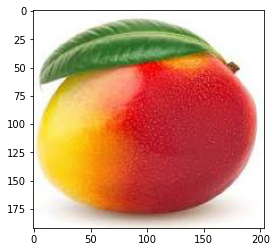

In [22]:
predict(alexnet_model, 'Fruits/predict/100.jpg')

Predicted Class: pinenapple
Apple Score: 0.00
Banana Score: 0.00
Grape Score: 0.00
mango Score: 0.00
orange Score: 0.00
pinenapple Score: 1.00
strawberries Score: 0.00
watermelon Score: 0.00


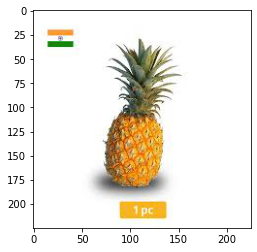

In [27]:
predict(alexnet_model, 'Fruits/predict/99.jpeg')

Predicted Class: orange
Apple Score: 0.00
Banana Score: 0.00
Grape Score: 0.00
mango Score: 0.00
orange Score: 1.00
pinenapple Score: 0.00
strawberries Score: 0.00
watermelon Score: 0.00


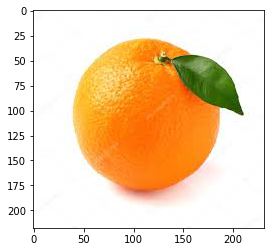

In [29]:
predict(alexnet_model, 'Fruits/predict/img_361.jpeg')